In [ ]:
%%bash
wget https://raw.githubusercontent.com/peto184/37/master/test.csv
wget https://raw.githubusercontent.com/peto184/37/master/train.csv

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import matplotlib.ticker as ticker

# To display all columns when printing
pd.set_option('display.max_columns', None)


# Opis dát spolu s ich charakteristikami


* Trenovaci dataset obsahuje 2800 samples
* Kazdy sample ma 43 features
  * 33 su kvalitativneho typu
  * 10 je kvantitativneho typu

* Kvalitativne features(33):
  * Nominalne(9): sex, referral_source, class, workclass, marital-status, relationship, race, native-country, occupation, 
  * Ordinalne(3): education, education-num, date_of_birth
  * Binarne(20): query on thyroxine, on antithyroid medication, thyroid surgery, I131 treatment, tumor, hypopituitary, T3 measured, TT4 measured, FTI measured, TBG measured, T4U measured, TSH measured, goitre, lithium, on thyroxine, pregnant, psych, query hyperthyroid, query hypothyroid, sick

* Kvantitativne features(10):
  * Diskretne(3): age, education-num, hours-per-week
  * Spojite(7): TSH, T3, TT4, T4U, fnlwgt, capital-gain, capital-loss
  
* Rozsahy a desktriptivne statistiky su rozpisane v grafoch a tabulkach nizsie.

# Identifikácia problémov v dátach


V datasete boli identifikovane nasledujuce problemy

* Problemy s formatovanim

```
[] FTI je zrejme numericka hodnota, no obsahuje '?' teda je typu Object. Je potrebne prepisat vsetky "?" na NaN a zmenit typ stlpca na numericky
[] capital_gain je vo formate float64 a capital_loss je vo formate int64
[OK] medical_info: vo formate json, treba pridat tieto hodnoty do dalsich stlpcov
[] date-of-birth: rozne formaty datumov
```


* Zbytocne stlpce

```
[] education a education-num vyjadruju rovnaku informaciu (education-num je zakodovane education, napriklad HighSchool = 9)
```


* Nevhodná štruktúra dát -> zvolit jednotny konzistetny zapis

```
[OK] referral_source: zmenit vsetko na lower case, niektore hodnoty su rovnake (Other a other, sVHD a SVHD)
[OK] relationship: other_relative a other-relative, rovnake stlpce iny format
[OK] on thyroxine : obsahuje nasledujuce hodnoty, treba opravit hodnoty [f,t,FALSE,F,T,TRUE] zmenit na [f,t]
[OK] query hypothyroid : obsahuje nasledujuce hodnoty, treba opravit hodnoty [f, nan, ??, t] zmenit na [f,t,nan]
[OK] class: treba premazat .|cislo na konci
```

* Chybajuce hodnoty
-> chybajuce hondnoty by sa dali bud vydedukovat pomocou ostatnych atributov, s ktorymi by mohli mat suvis, alebo ich doplnit modusom

```
NaN hodnoty:
[] age - 1
[] date_of_birth - 1
[] TSH - 284
[] T3 - 585
[] TT4 - 184
[] T4U - 297
[] capital-gain - 280

"?" hodnoty:
[] sex - 110
[] FTI - 295 
[] TBG - 2800 - zbytocny stlpec?

" ?" hodnoty:
[] workclass - 214 - dat vsetkych do private
[] occupation - 215 - dat vsetkych do other-service
[] native-country - 53 - dat vsetkych do USA alebo other?

```

* Vychylene a nezmyselne hodnoty
-> taketo hodnoty budeme riesit nahradenim napriklad medianovou hodnotou

```
[] age: nezmyselna hodnota veku 455
[] TSH: outliers
[] T3 : outliers
[] TT4: outliers
[] T4U: outliers
[] fnlwgt: outliers

[] capital-gain : cely IQR je v rozmedzi <0,0>, iba zopar hodnot je vyplnenych 	
[] capital-loss :  cely IQR je v rozmedzi <0,0>, iba zopar hodnot je vyplnenych 	
[] hours-per-week : zopar extremnych hodnot ako pracovna doba 99 hodin tyzdenne a zopar outlierov

```








# Nacitanie a vstupna analyza dat

In [2]:
data = pd.read_csv('train.csv', sep=',', index_col=0)

In [3]:
# Zoznam stlpcov typu 'object'
string_columns_list = data.dtypes[data.dtypes=='object'].index

# Zoznam stlpcov s numerickymi hodnotami
numerical_columns_list = data.dtypes[data.dtypes!='object'].index

In [4]:
data.head(5)

,age,sex,query on thyroxine,on antithyroid medication,thyroid surgery,I131 treatment,tumor,hypopituitary,TSH,T3 measured,T3,TT4 measured,TT4,T4U,FTI measured,FTI,TBG measured,TBG,referral source,class,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,capital-gain,capital-loss,hours-per-week,native-country,date_of_birth,medical_info
0,62.0,?,f,f,f,f,f,f,1.30,t,1.5,t,96.0,0.88,t,109,f,?,SVHC,negative.|3514,Federal-gov,35576,Some-college,10,Married-civ-spouse,Craft-repair,Husband,White,0.0,0,40,United-States,1956-02-17 00:00:00,"{'goitre':'f','TSH measured':'t','pregnant':'f..."
1,47.0,F,f,f,f,f,f,f,2.00,f,NaN,t,114.0,0.89,t,129,f,?,other,negative.|3576,Private,315291,HS-grad,9,Never-married,Adm-clerical,Unmarried,Black,0.0,0,40,United-States,1970-12-15,"{'goitre':'f','TSH measured':'t','pregnant':'f..."
2,64.0,F,f,f,f,f,f,f,0.68,t,1.4,t,92.0,0.81,t,114,f,?,SVI,negative.|1243,Private,134004,Some-college,10,Married-civ-spouse,Exec-managerial,Wife,White,0.0,0,40,United-States,1953-10-05,"{'goitre':'f','TSH measured':'t','pregnant':'f..."
3,20.0,F,f,f,f,f,f,f,1.30,t,1.7,t,104.0,0.96,t,108,f,?,other,negative.|3468,Private,161674,HS-grad,9,Never-married,Machine-op-inspct,Unmarried,White,NaN,0,40,United-States,1998-01-31 00 00 00,"{'goitre':'f','TSH measured':'t','pregnant':'f..."
4,21.0,F,f,f,f,f,f,f,0.40,t,3.4,t,189.0,1.35,t,140,f,?,other,increased binding protein.|338,Private,187264,HS-grad,9,Married-civ-spouse,Exec-managerial,Wife,White,0.0,0,55,United-States,1996-10-09 00 00 00,"{'goitre':'f','TSH measured':'t','pregnant':'f..."


In [5]:
data.describe()

,age,TSH,T3,TT4,T4U,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,2799.00000,2516.000000,2215.000000,2616.000000,2503.000000,2.800000e+03,2800.000000,2520.000000,2800.000000,2800.000000
mean,51.84423,4.672150,2.024966,109.072401,0.997912,1.901450e+05,10.096071,614.490873,409.752500,38.568214
std,20.46116,21.449453,0.824600,35.392443,0.194390,1.063478e+05,2.401259,4507.371485,15255.566016,11.867239
min,1.00000,0.005000,0.050000,2.000000,0.310000,1.228500e+04,1.000000,0.000000,-244400.000000,1.000000
25%,36.00000,0.440000,1.600000,88.000000,0.880000,1.192702e+05,9.000000,0.000000,0.000000,35.000000
50%,54.00000,1.400000,2.000000,104.000000,0.980000,1.782920e+05,10.000000,0.000000,0.000000,40.000000
75%,67.00000,2.600000,2.400000,125.000000,1.080000,2.343645e+05,12.000000,0.000000,0.000000,40.000000
max,455.00000,478.000000,10.600000,430.000000,2.120000,1.366120e+06,16.000000,99999.000000,220600.000000,99.000000


In [6]:
# Zoznam numerickych atributov
numerical_columns_list

Index(['age', 'TSH', 'T3', 'TT4', 'T4U', 'fnlwgt', 'education-num',
       'capital-gain', 'capital-loss', 'hours-per-week'],
      dtype='object')

In [7]:
# Zoznam kategorickych atributov
string_columns_list

Index(['sex', 'query on thyroxine', 'on antithyroid medication',
       'thyroid surgery', 'I131 treatment', 'tumor', 'hypopituitary',
       'T3 measured', 'TT4 measured', 'FTI measured', 'FTI', 'TBG measured',
       'TBG', 'referral source', 'class', 'workclass', 'education',
       'marital-status', 'occupation', 'relationship', 'race',
       'native-country', 'date_of_birth', 'medical_info'],
      dtype='object')

* Age - 1 NaN hodnota
* TSH - 284 NaN hodnot
* T3 - 585 NaN hodnot
* TT4 - 184 NaN hodnot
* T4U - 297 NaN hodnot
* capital-gain - 280 NaN hodnot
* date_of_birth - 1 NaN hodnota


In [8]:
# Vypisanie stlpcov s NaN hodnotami
for s in data.columns:
  num = data[s].isnull().sum()
  if num != 0:
    print("%s - %d" % (s, num))
        

age - 1
TSH - 284
T3 - 585
TT4 - 184
T4U - 297
capital-gain - 280
date_of_birth - 1


In [9]:
# Datove typy v tabulke
data.dtypes

age                          float64
sex                           object
query on thyroxine            object
on antithyroid medication     object
thyroid surgery               object
I131 treatment                object
tumor                         object
hypopituitary                 object
TSH                          float64
T3 measured                   object
T3                           float64
TT4 measured                  object
TT4                          float64
T4U                          float64
FTI measured                  object
FTI                           object
TBG measured                  object
TBG                           object
referral source               object
class                         object
workclass                     object
fnlwgt                         int64
education                     object
education-num                  int64
marital-status                object
occupation                    object
relationship                  object
r

In [10]:
# Vypisanie stlpcov s "?" hodnotami
for s in string_columns_list:
  num = len(data[data[s] == " ?"])
  if num != 0:
    print("%s - %d" % (s, num))


workclass - 214
occupation - 215
native-country - 53


In [11]:
# Vypisanie stlpcov s "?" hodnotami
for s in string_columns_list:
  num = len(data[data[s] == "?"])
  if num != 0:
    print("%s - %d" % (s, num))


sex - 110
FTI - 295
TBG - 2800


# Oprava medical_info do tabulkovej podoby

Priradenie hodnot z json sltpcu medical_info.

In [12]:
from pandas.io.json import json_normalize
import json

jsons = pd.DataFrame(data['medical_info'])
jsons['medical_info'] = jsons['medical_info'].apply(lambda x : x.replace('\'', '\"'))
jsons = jsons['medical_info'].apply(json.loads).values.tolist() 
medical_info = pd.DataFrame(jsons)
medical_info

,T4U measured,TSH measured,goitre,lithium,on thyroxine,pregnant,psych,query hyperthyroid,query hypothyroid,sick
0,t,t,f,f,f,f,f,f,f,f
1,t,t,f,f,f,f,f,f,f,f
2,t,t,f,f,f,f,f,f,t,f
3,t,t,f,f,f,f,f,f,f,f
4,t,t,f,f,f,f,f,t,f,f
5,t,t,f,f,f,f,f,f,f,f
6,t,t,f,f,f,f,f,f,f,f
7,t,t,f,f,t,f,f,f,f,f
8,t,t,f,f,f,f,f,f,f,f
9,f,t,f,f,f,f,f,f,f,f


In [13]:
data = pd.concat([data, pd.DataFrame(medical_info)], axis=1)
data = data.drop(columns=['medical_info'])

# Oprava formatovania

In [14]:
# Zmena velkych pismenok na male, aby sa opravilo formatovanie
data['referral source'] = data['referral source'].apply(lambda x : x.lower())

In [15]:
# Odseknutie .| zo stlpca class
data['class'] = data['class'].apply(lambda x : x.split('.')[0])

In [16]:
# Zmena _ na - pri relationship
data['relationship'] = data['relationship'].apply(lambda x : x.replace('-','_'))

In [17]:
# Oprava nekonzistentnych oznaceni hodnot
dict = {'FALSE':'f', 'F':'f', 'T':'t', 'TRUE':'t', 'f':'f', 't':'t', 'nan':'?', '??':'?'}
data['on thyroxine'] = data['on thyroxine'].apply(lambda x : dict[x])
data['query hypothyroid'] = data['query hypothyroid'].apply(lambda x : dict[x])

In [18]:
# Zoznam stlpcov typu 'object'
string_columns_list = data.dtypes[data.dtypes=='object'].index

# Zoznam stlpcov s numerickymi hodnotami
numerical_columns_list = data.dtypes[data.dtypes!='object'].index

# Age, date_of_birth
* je mozne zistit vek z oboch atributov
* age obsahuje outlier 455, bude nahradene mean hodnotou
* date_of_birth - nekonzistnetne formaty bude potrebne ich zjednotit

In [19]:
data['age'].describe()

count    2799.00000
mean       51.84423
std        20.46116
min         1.00000
25%        36.00000
50%        54.00000
75%        67.00000
max       455.00000
Name: age, dtype: float64

Number of null elements in age:  1
Number of non null elements in age:  2799


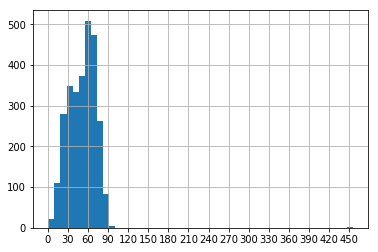

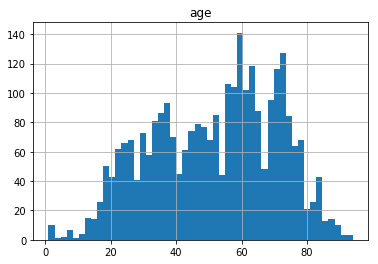

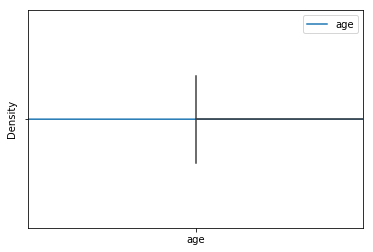

In [20]:
age = pd.Series(data['age'])
ageNullCount = age.isnull().sum()
ageNotNullCount = age.notnull().sum()
print("Number of null elements in age: ", ageNullCount)
print("Number of non null elements in age: ", ageNotNullCount)

age = age.dropna()

ax = plt.axes()
ax.xaxis.set_major_locator(ticker.MultipleLocator(30))

# histogram s outlierom
age.hist(bins = 50)

df = pd.DataFrame(age)
sortedAges = df.sort_values(by='age')
sortedAges.drop(sortedAges.tail(1).index,inplace=True)

# histogram bet outliera
sortedAges.hist(bins = 50)

sortedAges.plot(kind='KDE')
age.plot(kind='box')
sb.boxplot(sortedAges, sym='k.')

# Sex
* chybajuce hodnoty sa budu data v niektorych pripadoch doplnit pomocou atributu __relationship__, ktory obsahuje hodnoty husband a wife, alebo z atributu __pregnant__, pokial by islo o zenske pohlavie

In [21]:
data['sex'].describe()

count     2800
unique       3
top          F
freq      1830
Name: sex, dtype: object

In [22]:
sex = data['sex']
sexDf = pd.DataFrame(sex)
sexNullCount = sexDf[sexDf['sex']=='?'].count()[0]
sexNotNullCount = sex.notnull().sum()
menCount = sexDf[sexDf['sex']=='M'].count()[0]
womenCount = sexDf[sexDf['sex']=='F'].count()[0]
print('Number of null sex values: ',sexNullCount)
print('Number of non null sex values: ',sexNotNullCount)
print('Number men values: ',menCount)
print('Number women values: ',womenCount)

Number of null sex values:  110
Number of non null sex values:  2800
Number men values:  860
Number women values:  1830


In [ ]:
sex.hist()

In [ ]:
sex_age = data[['sex','age']]

sex_age = sex_age[sex_age['age']!=sex_age['age'].max()]
sex_age = sex_age[sex_age['sex']!='?']Tsex_age.groupby('sex').age.hist(bins = 50)

# T-markre a tumor (T3, TT4, TSH, T4U, fnlwgt)

Ako mozno vidiet z grafu nizsie, kazdy z markrov obsahuje outlieri. 
* pozor: vertikalna os je v logaritmickej skale

In [ ]:
marker_columns = ['TSH', 'T3', 'TT4', 'T4U', 'fnlwgt']

In [ ]:
data[marker_columns].describe()

In [ ]:
g = sb.boxplot(data=data[marker_columns].dropna())
g.set_yscale('log')

Ako mozno vidiet z grafu, kazdy z markrov obsahuje outlieri.
    pozor: vertikalna os je v logaritmickej skale



In [ ]:
# pairplot ofarbeny triedou class
sb.pairplot(data[["T3", "TT4","TSH", "T4U","tumor", "class", "age", "fnlwgt"]].dropna(), hue = 'class')

In [ ]:
sb.pairplot(data[["class", "education-num", "capital-gain", "capital-loss", "hours-per-week"]].dropna(), hue = 'class')

In [ ]:
# Korelacia numberickych atriburov
fig, ax = plt.subplots(figsize=(10,8))
sb.heatmap(data[numerical_columns_list].corr(), ax=ax, annot=True, fmt=".3f")

In [ ]:
sb.regplot(x="T3", y="TT4", data=data)

In [ ]:
sb.regplot(x="T3", y="TSH", data=data)

In [ ]:
sb.regplot(x="T3", y="T4U", data=data)
#plt.scatter(data["T3"], data["TT4"])

In [ ]:
sb.regplot(x="TT4", y="T4U", data=data)

In [ ]:
sb.regplot(x="TT4", y="TSH", data=data)

*Na* tomto grafe vidno korelacie medzi numerickymi premennymi. Nieje na nom vidno nic extra zaujimave. Niektore hodnoty spolu koreluju ale slabo. (TT4 a T3)

# Kategoricke atribúty: Relationship, Occupation, education, etc...

In [ ]:
temp = data[string_columns_list]
temp.head()

In [ ]:
temp.describe()

In [ ]:
# Atribut workclass

# Vyskyt hodnot
print(data[['workclass']].apply(pd.Series.value_counts))
data['workclass'].value_counts().plot(kind='bar')

In [ ]:
# Atribut occupation

# Vyskyt hodnot
print(data[['occupation']].apply(pd.Series.value_counts))
data['occupation'].value_counts().plot(kind='bar')

In [ ]:
# Atribut education

# Vyskyt hodnot
print(data[['education']].apply(pd.Series.value_counts))
data['education'].value_counts().plot(kind='bar')

In [ ]:
# Atribut education-num

# Vyskyt hodnot
print(data[['education-num']].apply(pd.Series.value_counts))
data['education-num'].value_counts().plot(kind='bar')

education-num a education vyjadruju rovnaku informaciu. Duplicitny sltpec. Pocet hodnot sa zhoduje

In [ ]:
# Atribut marital-status

# Vyskyt hodnot
print(data[['marital-status']].apply(pd.Series.value_counts))
data['marital-status'].value_counts().plot(kind='bar')

In [ ]:

# Atribut relationship

# Vyskyt hodnot
print(data[['relationship']].apply(pd.Series.value_counts))
data['relationship'].value_counts().plot(kind='bar')

In [ ]:
# Atribut race

# Vyskyt hodnot
print(data[['race']].apply(pd.Series.value_counts))
data['race'].value_counts().plot(kind='bar')

In [ ]:
# Atribut referral source

# Vyskyt hodnot
print(data[['referral source']].apply(pd.Series.value_counts))
data['referral source'].value_counts().plot(kind='bar')

In [ ]:
temp = pd.crosstab(index=data['occupation'], columns=data["education"], normalize='index')
temp.index = data['occupation'].value_counts().index
sb.heatmap(temp, annot=True, fmt=".1f")

In [ ]:
data[['capital-gain', 'capital-loss', 'hours-per-week']].describe()

In [ ]:
sb.boxplot(data=data[['capital-gain','capital-loss']].dropna())

Cely IQR je v v intervale <0,0> a len zopar hodnot je vyplnenych, teda su vsetky outliers

In [ ]:
sb.boxplot(data=data[['hours-per-week']].dropna())

Zopar extremnych? hodnot ako pracovna doba 99h/tyzden.

# Bool columns

In [ ]:
bool_columns_list = ['query on thyroxine', 'on antithyroid medication', 'thyroid surgery', 'I131 treatment', 'tumor', 'hypopituitary', 'T3 measured', 'TT4 measured', 'FTI measured', 'TBG measured', 'T4U measured', 'TSH measured', 'goitre', 'lithium', 'on thyroxine', 'pregnant', 'psych', 'query hyperthyroid', 'query hypothyroid', 'sick']

In [ ]:
value_counts = data[bool_columns_list].apply(pd.Series.value_counts).transpose()
value_counts.plot(kind="bar")
value_counts.plot.bar(stacked=True)
value_counts

In [ ]:
sb.barplot(data=value_counts.transpose(), orient='h')

V tabulke vidno rozlozenie roznych t/f hodnot v bool sltpcoch. Niektore stlpce ako TBG measured su vsetky false. Niektore stlpce ako query hypothroid maju ? hodnoty.

# Porovnanie markrov s atributom class

In [ ]:
t3ctab = pd.crosstab(index=data["T3"],  columns=[data["class"]], margins=False)
print("max pocetnost vyskytov s increased binding protein: ", t3ctab["increased binding protein"].max(), end=', ')
print("s hodnotou: ", t3ctab["increased binding protein"].idxmax())
print("min pocetnost vyskytov s increased binding protein: ", t3ctab["increased binding protein"].min(), end=', ')
print("s hodnotou: ", t3ctab["increased binding protein"].idxmin())
print()
print("max pocetnost vyskytov decreased binding protein: ", t3ctab["decreased binding protein"].max(), end=', ')
print("s hodnotou: ", t3ctab["decreased binding protein"].idxmax())
print("min pocetnost vyskytov decreased binding protein: ", t3ctab["decreased binding protein"].min(), end=', ')
print("s hodnotou: ", t3ctab["decreased binding protein"].idxmin())
print()
print("max pocetnost vyskytov negative: ", t3ctab["negative"].max(), end=', ')
print("s hodnotou: ", t3ctab["negative"].idxmax())
print("min pocetnost vyskytov negative: ", t3ctab["negative"].min(), end=', ')
print("s hodnotou: ", t3ctab["negative"].idxmin())
print()
t3ctab.plot()

In [ ]:
tt4ctab = pd.crosstab(index=data["TT4"],  columns=[data["class"]], margins=False)
print("max pocetnost vyskytov s increased binding protein: ", tt4ctab["increased binding protein"].max(), end=', ')
print("s hodnotou: ", tt4ctab["increased binding protein"].idxmax())
print("min pocetnost vyskytov s increased binding protein: ", tt4ctab["increased binding protein"].min(), end=', ')
print("s hodnotou: ", tt4ctab["increased binding protein"].idxmin())
print()
print("max pocetnost vyskytov decreased binding protein: ", tt4ctab["decreased binding protein"].max(), end=', ')
print("s hodnotou: ", tt4ctab["decreased binding protein"].idxmax())
print("min pocetnost vyskytov decreased binding protein: ", tt4ctab["decreased binding protein"].min(), end=', ')
print("s hodnotou: ", tt4ctab["decreased binding protein"].idxmin())
print()
print("max pocetnost vyskytov negative: ", tt4ctab["negative"].max(), end=', ')
print("s hodnotou: ", tt4ctab["negative"].idxmax())
print("min pocetnost vyskytov negative: ", tt4ctab["negative"].min(), end=', ')
print("s hodnotou: ", tt4ctab["negative"].idxmin())
print()
tt4ctab.plot()

In [ ]:
t4uctab = pd.crosstab(index=data["T4U"],  columns=[data["class"]], margins=False)
print("max pocetnost vyskytov s increased binding protein: ", t4uctab["increased binding protein"].max(), end=', ')
print("s hodnotou: ", t4uctab["increased binding protein"].idxmax())
print("min pocetnost vyskytov s increased binding protein: ", t4uctab["increased binding protein"].min(), end=', ')
print("s hodnotou: ", t4uctab["increased binding protein"].idxmin())
print()
print("max pocetnost vyskytov decreased binding protein: ", t4uctab["decreased binding protein"].max(), end=', ')
print("s hodnotou: ", t4uctab["decreased binding protein"].idxmax())
print("min pocetnost vyskytov decreased binding protein: ", t4uctab["decreased binding protein"].min(), end=', ')
print("s hodnotou: ", t4uctab["decreased binding protein"].idxmin())
print()
print("max pocetnost vyskytov negative: ", t4uctab["negative"].max(), end=', ')
print("s hodnotou: ", t4uctab["negative"].idxmax())
print("min pocetnost vyskytov negative: ", t4uctab["negative"].min(), end=', ')
print("s hodnotou: ", t4uctab["negative"].idxmin())
print()
t4uctab.plot()

In [ ]:
tshctab = pd.crosstab(index=data["TSH"],  columns=[data["class"]], margins=False)
print("max pocetnost vyskytov s increased binding protein: ", tshctab["increased binding protein"].max(), end=', ')
print("s hodnotou: ", tshctab["increased binding protein"].idxmax())
print("min pocetnost vyskytov s increased binding protein: ", tshctab["increased binding protein"].min(), end=', ')
print("s hodnotou: ", tshctab["increased binding protein"].idxmin())
print()
print("max pocetnost vyskytov decreased binding protein: ", tshctab["decreased binding protein"].max(), end=', ')
print("s hodnotou: ", tshctab["decreased binding protein"].idxmax())
print("min pocetnost vyskytov decreased binding protein: ", tshctab["decreased binding protein"].min(), end=', ')
print("s hodnotou: ", tshctab["decreased binding protein"].idxmin())
print()
print("max pocetnost vyskytov negative: ", tshctab["negative"].max(), end=', ')
print("s hodnotou: ", tshctab["negative"].idxmax())
print("min pocetnost vyskytov negative: ", tshctab["negative"].min(), end=', ')
print("s hodnotou: ", tshctab["negative"].idxmin())
print()
tshctab.plot()

In [ ]:
pd.crosstab(index=data["race"],  columns=[data["class"]], normalize = "index").plot.bar()

Ako mozeme vidiet v grafe vyssie, trieda nezavisi od rasy

In [ ]:
pd.crosstab(index=data["race"],  columns=[data["T3"]], normalize = "index").transpose().plot()

Marker T3 rastie priblizne rovnako pre vsetky rasy

In [ ]:
pd.crosstab(index=data["race"],  columns=[data["TT4"]], normalize = "index").transpose().plot()

Atribut TT4 rastie priblizne rovnako pre vsetky rasy.

In [ ]:
pd.crosstab(index=data["race"],  columns=[data["T4U"]], normalize = "index").transpose().plot()

Atribut T4U rastie priblizne rovnako pre vsetky rasy.

In [ ]:
pd.crosstab(index=data["race"],  columns=[data["TSH"]], normalize = "index").transpose().plot()

Atribut TSH rastie priblizne rovnako pre vsetky rasy.

In [ ]:
pd.crosstab(index=data["pregnant"],  columns=[data["TSH"]], normalize = "index").transpose().plot()

In [ ]:
pd.crosstab(index=data["class"],  columns=[data["capital-gain"]], normalize = "index").transpose().plot()

In [ ]:
pd.crosstab(index=data["sick"],  columns=[data["class"]], normalize = "index").transpose().plot()

# Záver

Vykonali sme prieskumnú analýzu nášho datasetu. Zistili sme, že v datasete sa nachádzajú chyby, ako nekonzistetné zápisy hodnôt pri kategorických atribútoch, ktoré bude treba zjednotiť. Taktiež sa v dátach nachádza mnoho prázdnych, hodnôt, ktoré bude treba nejaký spôsobom vyplniť. Pri numerických atribútoch to môžeme spraviť napríklad doplnením mediánom. Pri kategorických atribútoch buď necháme nedefinovanú hodnotu, alebo doplníme hodnotu modusom. Dáta sme vizualizovali pomocou grafov, v ktorých sme sa snažili zachytiť závislosť niektorých atribútov s atribútom class. V ďalšej časti projektu budeme tieto chyby opravovať a ďalej sa rozhodovať, ktoré atribútu budú ďalej využít pri strojovom učení. 